Load Dependencies

In [1]:
using Catlab
using Catlab.Graphics
using CombinatorialSpaces
using Decapodes
using DiagrammaticEquations, DiagrammaticEquations.Deca
using Distributions
using MLStyle
using OrdinaryDiffEq
using LinearAlgebra
using ComponentArrays
using CairoMakie
using GeometryBasics: Point2, Point3
Point2D = Point2{Float64}
Point3D = Point3{Float64}

GeometryBasics.Point{3, Float64}

Load in our Decapodes models

In [2]:
using Decapodes.Canon.Oncology

Examine our models
Note that the implementation is entirely specified by its documentation

In [3]:
@doc invasion

@doc logistic

@doc gompertz

# Gompertz

[Source](https://en.wikipedia.org/wiki/Gompertz_function)

Eq. 6 from Yi et al.   A Review of Mathematical Models for Tumor Dynamics and Treatment Resistance   Evolution of Solid Tumors

## Model

```
(C, fC)::Form0
              
Cmax::Constant
              
fC == C * ln(Cmax / C)
```


Load in a mesh, initial conditions, and a plotting function

In [4]:
function show_heatmap(Cdata)
  heatmap(reshape(Cdata, (floor(Int64, sqrt(length(Cdata))), floor(Int64, sqrt(length(Cdata))))))
end

s = triangulated_grid(50,50,0.2,0.2,Point2D);
sd = EmbeddedDeltaDualComplex2D{Bool, Float64, Point2D}(s);
subdivide_duals!(sd, Circumcenter());

constants_and_parameters = (
  invasion_Dif = 0.005,
  invasion_Kd = 0.5,
  Cmax = 10)

(invasion_Dif = 0.005, invasion_Kd = 0.5, Cmax = 10)

"The model ... considers an equivalent radially symmetric tumour"
- Murray J.D., Glioblastoma brain tumours

In [5]:
c_dist  = MvNormal([25, 25], 2)
C = 100 * [pdf(c_dist, [p[1], p[2]]) for p in sd[:point]]

u₀ = ComponentArray(C=C)

ComponentVector{Float64}(C = [5.511214862387883e-68, 1.9092775400857783e-67, 6.548851755254674e-67, 2.2240043394148634e-66, 7.477914169088552e-66, 2.4894287267884957e-65, 8.205277862067283e-65, 2.6776959591999733e-64, 8.65174297332636e-64, 2.76770838562399e-63  …  4.931812766956773e-63, 1.5493611873482188e-63, 4.8191799040821854e-64, 1.484116457322235e-64, 4.52519394953736e-65, 1.3660946469233806e-65, 4.0831821701849867e-66, 1.2083454136756992e-66, 3.5404446954827926e-67, 1.0270673098994496e-67])

Compose our Proliferation-Invasion models

In [6]:
proliferation_invasion_composition_diagram = @relation () begin
  proliferation(C, fC, Cmax)
  invasion(C, fC, Cmax)
end

logistic_proliferation_invasion_cospan = oapply(proliferation_invasion_composition_diagram,
  [Open(logistic, [:C, :fC, :Cmax]),
   Open(invasion, [:C, :fC, :Cmax])])

logistic_proliferation_invasion = apex(logistic_proliferation_invasion_cospan)

gompertz_proliferation_invasion_cospan = oapply(proliferation_invasion_composition_diagram,
  [Open(gompertz, [:C, :fC, :Cmax]),
   Open(invasion, [:C, :fC, :Cmax])])

gompertz_proliferation_invasion = apex(gompertz_proliferation_invasion_cospan)

Var,type,name
1,Form0,C
2,Form0,fC
3,Constant,Cmax
4,infer,proliferation_•1
5,infer,proliferation_•2
6,Constant,invasion_Dif
7,Constant,invasion_Kd
8,infer,invasion_Ċ
9,infer,invasion_•2
10,infer,invasion_•3


Generate the logistic simulation

In [7]:
logistic_sim = evalsim(logistic_proliferation_invasion)

lₘ = logistic_sim(sd, default_dec_generate, DiagonalHodge())

(::Decapodes.var"#f#80"{PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, SparseArrays.SparseMatrixCSC{Float64, Int32}}) (generic function with 1 method)

Execute the logistic simulation

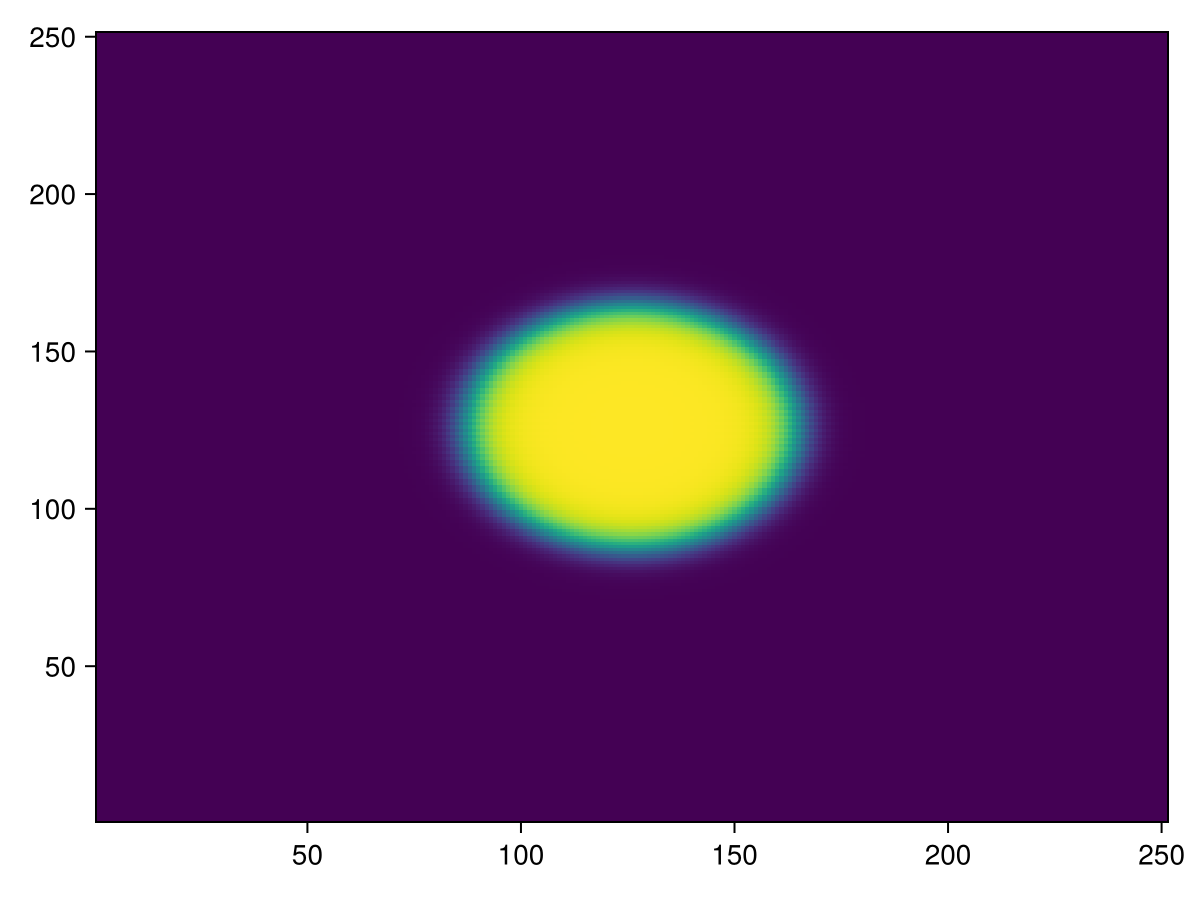

In [8]:
tₑ = 15.0

prob = ODEProblem(lₘ, u₀, (0, tₑ), constants_and_parameters)
logistic_soln = solve(prob, Tsit5())

show_heatmap(logistic_soln(tₑ).C)

Generate the Gompertz simulation

In [9]:
gompertz_sim = evalsim(gompertz_proliferation_invasion)
gₘ = gompertz_sim(sd, default_dec_generate, DiagonalHodge())

(::Decapodes.var"#f#85"{PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, SparseArrays.SparseMatrixCSC{Float64, Int32}, Decapodes.var"#44#48"{Decapodes.var"#43#47"}}) (generic function with 1 method)

Execute the Gompertz simulation

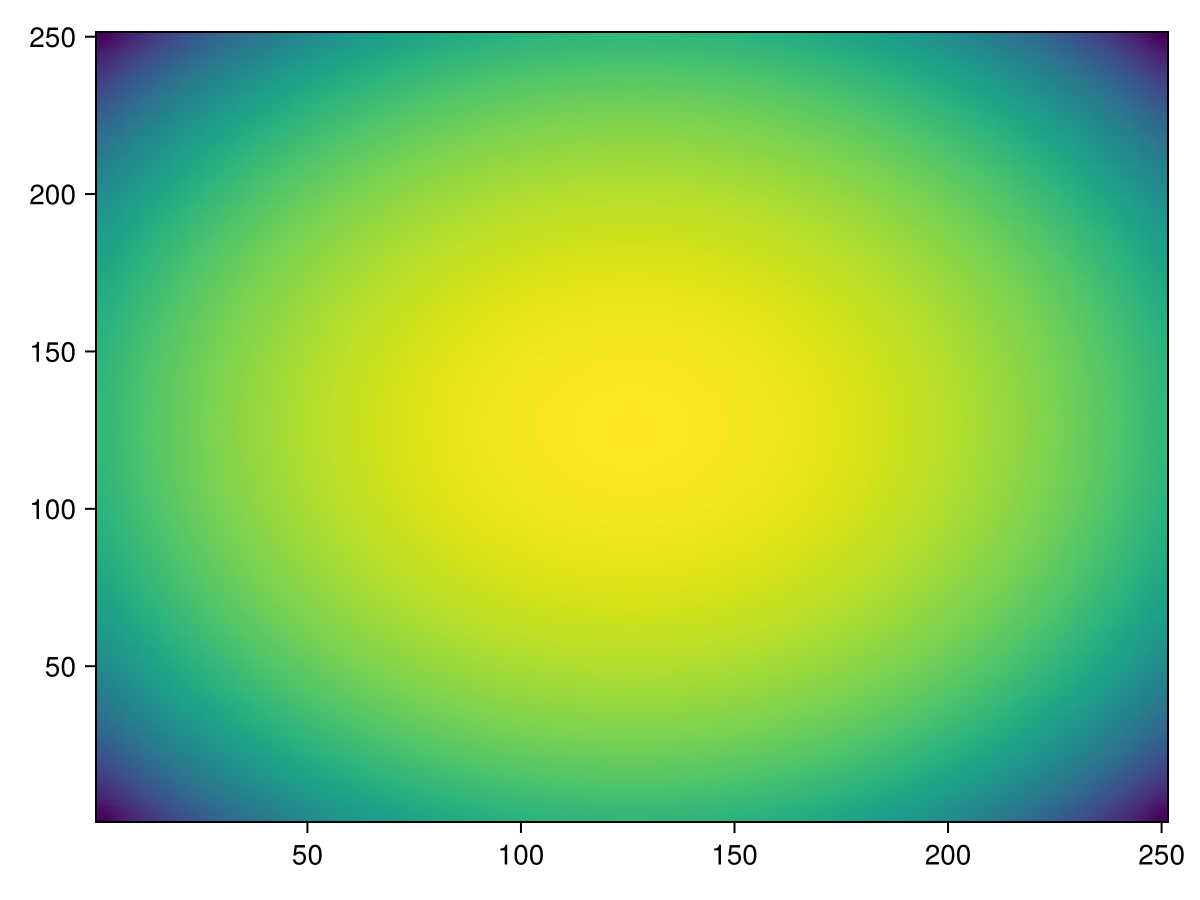

In [10]:
prob = ODEProblem(gₘ, u₀, (0, tₑ), constants_and_parameters)
gompertz_soln = solve(prob, Tsit5())

show_heatmap(gompertz_soln(tₑ).C)